# 1. Import Libraries and Reading the Data

In [345]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Preprocessing
import re # Handling HTML tags and URLs
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup #HTML tags
from contractions import contractions_dict, fix

import spacy
from spacy.lang.en import English

spacy.cli.download("en_core_web_sm")

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer # Stemming or lemmatization
import string # remove punctuation
import contractions


# Download NLTK stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.data.path.append("C:\\Users\\tmost/nltk_data")


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Utilities
from tqdm import tqdm # progeress bar

# Jupyter Notebook Specific
%matplotlib inline

# Warning Settings
import warnings
warnings.filterwarnings("ignore")

# Pickle for Serialization
import pickle

# spilit data
from sklearn.model_selection import train_test_split

# Vectorization for feature extraction
from sklearn.feature_extraction.text import CountVectorizer #converting a collection of text doc to a matrix of token counts.

from scipy.stats import entropy
from scipy.special import rel_entr


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tmost\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## Reading the data

data = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/Reviews.csv')
print(data.shape)

(568454, 10)


## 2. EDA

### Data Understanding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Check missing values

In [5]:
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

### Check duplicate data

#### across rows

In [6]:
anyduplicate_row = data.duplicated().any()  # checks for duplicated rows across all columns.
anyduplicate_row

False

#### Check for duplicated data within individual columns

In [7]:
for column in data.columns:
    column_has_duplicates = data[column].duplicated().any()
    print(f"Column '{column}' has duplicates: {column_has_duplicates}")

Column 'Id' has duplicates: False
Column 'ProductId' has duplicates: True
Column 'UserId' has duplicates: True
Column 'ProfileName' has duplicates: True
Column 'HelpfulnessNumerator' has duplicates: True
Column 'HelpfulnessDenominator' has duplicates: True
Column 'Score' has duplicates: True
Column 'Time' has duplicates: True
Column 'Summary' has duplicates: True
Column 'Text' has duplicates: True


In [8]:
duplicate_entry = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
duplicate_entry.shape
#keep false, marked the duplicated elements

(232415, 10)

In [9]:
duplicate_entry.sample(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
217076,217077,B003X0TRGW,A2GC5JELY3N07V,bman,0,0,4,1317600000,Beats Cinnamon Toast Crunch,"Looking for a change, I decided to pick up a b..."
496562,496563,B0029NIPSA,A2T5VEAFT6PUH3,"J. Hollister ""Judy says""",0,0,5,1337040000,Lamby delicious,Our westies love the Caesar Canine Cuisine foo...
359383,359384,B007M832YY,A3T0OTH5072YRE,"M. Reynard ""kairosdreaming""",0,0,3,1337299200,Pop Chips Barbeque Potato Chips,"My local store was running a special on these,..."


### Drop Duplicated data

- During basic data cleaning, we identified redundant entries where users provided the same review for different products simultaneously. To address this, we'll keep only the first occurrence and remove subsequent duplicates.

In [384]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)

print('Number of samples in original dataset: %d' % (data.shape[0]))  # original dataset
print('Number of samples after removing duplicates: %d' % (df.shape[0]))
print('Percentage of the remaining sampels: %.1f%% ' % (df.shape[0]*100/data.shape[0]))

Number of samples in original dataset: 568454
Number of samples after removing duplicates: 393933
Percentage of the remaining sampels: 69.3% 


If some columns are being considered in the removal of duplicates, it because of the values in these columns are being used to identify and distinguish between duplicate rows. e.g.,, the subset of columns ('UserId', 'ProfileName', 'Time', and 'Text') is crucial in determining whether two rows are considered duplicates.

- Now our data points got reduced to about 69%.

## 3.Feature Engineering

- Create new columnns **"usefulness"** by analyzing "HelpfulnessNumerator" and "HelpfulnessDenominator"

- What are the differences?
    
    
- HelpfulnessNumerator = Represent the number of people who found the review helpful.


- HelpfulnessDenominator = Represent the number of people who found the review, whether they found it j´helpful or not.

In [13]:
df['usefulness'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
df.usefulness[105:110] # randomly check the values

106    0.25
107    1.00
108    1.00
109     NaN
110    1.00
Name: usefulness, dtype: float64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393933 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      393933 non-null  int64  
 1   ProductId               393933 non-null  object 
 2   UserId                  393933 non-null  object 
 3   ProfileName             393922 non-null  object 
 4   HelpfulnessNumerator    393933 non-null  int64  
 5   HelpfulnessDenominator  393933 non-null  int64  
 6   Score                   393933 non-null  int64  
 7   Time                    393933 non-null  int64  
 8   Summary                 393930 non-null  object 
 9   Text                    393933 non-null  object 
 10  usefulness              209310 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 44.1+ MB


>> Categorized the "usefulness" based on certain conditions


- If the value is greater than 0.75, it appends ">75%" to the 'usefulness' list.


- If the value is less than 0.25, it appends "<25%" to the 'usefulness' list.


- If the value is between 0.25 and 0.75 (inclusive), it appends "25-75%" to the 'usefulness' list.


- If none of the above conditions are met, it appends "useless" to the 'usefulness' list.

In [15]:
usefulness = [] # this columns convert from float to object
for i in df['usefulness']:
    if i > 0.75:
        usefulness.append(">75%")
    elif i < 0.25:
        usefulness.append("<25%")
    elif i >= 0.25 and i <= 0.75:
        usefulness.append("25-75%")
    else:
        usefulness.append("useless")
df['usefulness']  = usefulness  

In [16]:
print(df.shape)
df.columns

(393933, 11)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'usefulness'],
      dtype='object')

### Distribution of usefulness

In [447]:
##TBD: Change it to piechart

category_counts = df['usefulness'].value_counts() # usefulness categorical

# Plotting with adjustments
plt.figure(figsize=(6, 4)) 
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Usefulness Categories')
plt.ylabel('Count')
plt.title('Distribution of Usefulness Categories')
plt.text(0.5, max(category_counts.values) + 5, '', horizontalalignment='center', verticalalignment='bottom', fontsize=10)
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 2, str(count), horizontalalignment='center', verticalalignment='bottom', fontsize=10)

plt.show()

KeyError: 'usefulness'

- provides a comparative analysis of 'usefulness' within different 'Score' categories using a specialized count plot

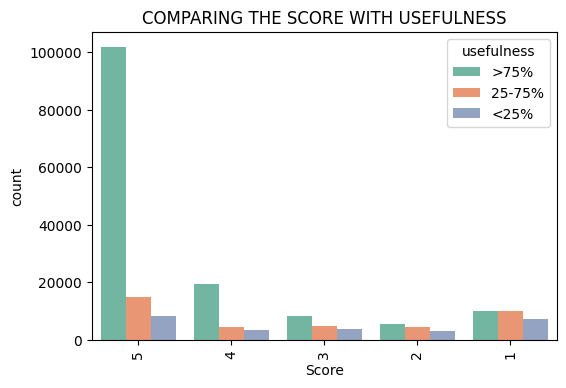

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='Score',data=df,hue='usefulness',hue_order=['>75%','25-75%','<25%'],order=[5,4,3,2,1],palette="Set2")
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

- Create a new column **'word_count'** containing the word count for each review text. This can be useful for analyzing and understanding the length or complexity of the reviews in terms of the number of words.

In [19]:
word_count = []
for i in df['Text']:
    word_count.append(len(i.split()))
df['word_count'] = word_count    

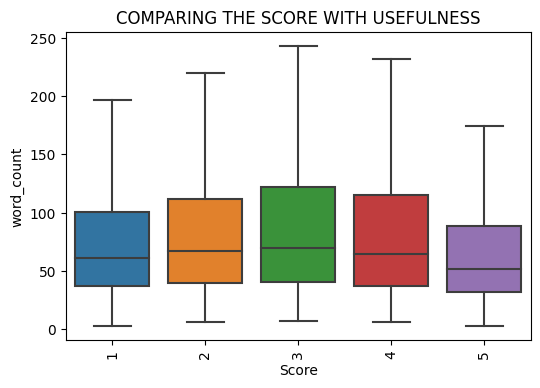

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Score',y='word_count',data=df,showfliers=False)
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

The plot shows that usually for very positive and very negative commnets shorter texts are written, while for the middle rate (3) the comments are the longest (probably users write both positive and negative aspects.)

###  Count of Reviews by stars

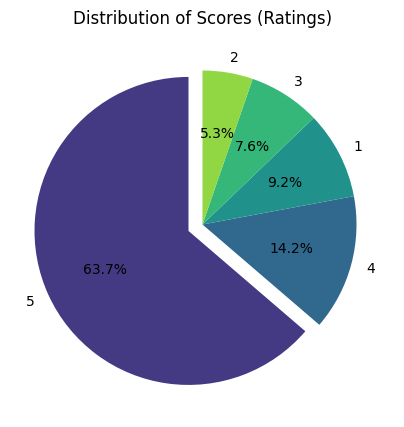

In [21]:
# Assuming 'Score' is the column containing ratings in your DataFrame
plt.figure(figsize=(5, 5))

# Sort the DataFrame by 'Score'
df_sorted = df.sort_values(by='Score')

# Define a custom color palette
custom_palette = sns.color_palette("viridis", n_colors=len(df_sorted['Score'].unique()))

score_counts = df_sorted['Score'].value_counts()
labels = score_counts.index
explode = (0.1, 0, 0, 0, 0)  # Explode the first slice (optional)

plt.pie(score_counts, labels=labels, colors=custom_palette, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of Scores (Ratings)')
plt.show()



- Create new columns **"Sentiment"** based on the values in the existing 'Score' columns. The logic is a s follows:
    
    
    - If the 'Score' is greater than 3, the corresponding sentiment is set to 'positive'.
    
    
    - If the 'Score' is less than 3, the sentiment is set to 'negative'.
    
    
    - If the 'Score' is exactly 3, the sentiment is set to 'not'.
    

In [388]:
sentiment = []
for i in df['Score']:
    if i > 3:
        sentiment.append('positive')
    elif i < 3:
        sentiment.append('negative')
    else:
        sentiment.append('not')
df['sentiment'] = sentiment   

In [24]:
positive_rev = df[df.sentiment=='positive']
positive_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,>75%,48,positive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,>75%,94,positive


In [25]:
Negative_rev = df[df.sentiment=='negative']
Negative_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless,31,negative
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,>75%,41,negative


**WordCloud Class**:


The WordCloud class from the wordcloud library generates visual representations of text data, sizing words based on frequency. It allows customization of parameters like image size, color schemes, and fonts.


**STOPWORDS**:

STOPWORDS, a set of common words (e.g., "the," "and," "is"), are often excluded in text analysis as they contribute little meaning. In WordCloud, the stopwords parameter excludes specific words from the generated word cloud.

In [395]:

stopwords_wc = set(STOPWORDS)

def wordcloud_map(dataset, field):
    
    # Positive Word Cloud
    comment_words_positive = ''
    for val in dataset[dataset.sentiment=='positive'][field]:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words_positive += " ".join(tokens) + " "

    wordcloud_positive = WordCloud(width=600, height=600,
                                   background_color='green',
                                   stopwords=stopwords_wc,
                                   min_font_size=10).generate(comment_words_positive)

    # Negative Word Cloud
    comment_words_negative = ''
    for val in dataset[dataset.sentiment=='negative'][field]:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words_negative += " ".join(tokens) + " "

    wordcloud_negative = WordCloud(width=600, height=600,
                                   background_color='yellow',
                                   stopwords=stopwords_wc,
                                   min_font_size=10).generate(comment_words_negative)

    # Plotting side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Positive Word Cloud
    axes[0].imshow(wordcloud_positive, interpolation='bilinear')
    axes[0].set_title('Positive Word Cloud')
    axes[0].axis('off')

    # Negative Word Cloud
    axes[1].imshow(wordcloud_negative, interpolation='bilinear')
    axes[1].set_title('Negative Word Cloud')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

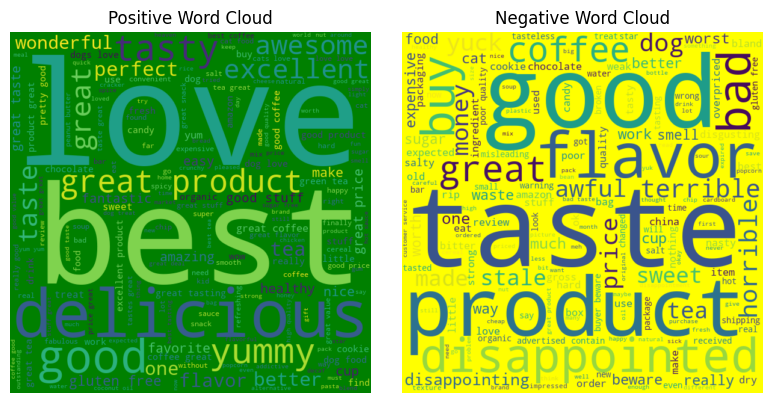

In [398]:
# World Cloud for the summaries.
wordcloud_map(df,'Summary')

## 4.Preprocessing the Text Data

### Base Preprocessing 
1. Remove URLs 
2. Remove HTML Tags
3. Remove punctuations
4. Remove numerical values
5. Remove emotions and special characters
6. Lowercase
7. Remove Stopwords


### Additional Processing  
#### - Lemmatization and Stemming

Stemming and lemmatization both simplify words by reducing inflectional and sometimes derivational forms to a common base form. However, stemming uses a simple heuristic process, often removing derivational affixes, while lemmatization uses a more sophisticated approach with vocabulary and morphological analysis to preserve the base or dictionary form, known as the lemma.

In this study only Stemming is considered.

#### - Extracting only adjectives, nouns, verbs, and adverbs

### Vectorization
- Convert text into numerical vectors. In our case, Bag of Words model is studied.

In [28]:
# English Stopwords
stopwords_set = set(stopwords.words('english'))

# Make the text lower case, tokenize, and remove stopwords
def remove_stopwords(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    text = ' '.join(word for word in word_tokens if word not in stopwords_set)
    return text


preprocessed_reviews = [] # Initialize with empty list to store preprocessed reviews 

# tqdm is for printing the status bar
for sentence in tqdm(df['Text'].values):
    # Remove URLs
    sentence = re.sub(r"http\S+", "", sentence)
    # Remove HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    # Decontract text - Use contractions.fix from the contractions library
    sentence = contractions.fix(sentence)
    # Remove extra spaces and numbers
    sentence = re.sub(r"\S*\d\S*", "", sentence).strip()
    # Remove non-alphabetic characters
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
    # Lower case and remove stop words
    sentence = remove_stopwords(sentence)
    # Append the preprocessed sentence to the list
    preprocessed_reviews.append(sentence.strip())
    

100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [06:45<00:00, 972.57it/s]


In [103]:
# Applying stemming to the base processed data. 
ps = PorterStemmer()

# Apply stemming
def stemming(text):
    word_tokens = word_tokenize(text)
    text = ' '.join(ps.stem(word) for word in word_tokens)
    return text

preprocessed_reviews_stemmed = []
for sentence in tqdm(preprocessed_reviews):
    preprocessed_reviews_stemmed.append(stemming(sentence))
    

100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [08:40<00:00, 757.44it/s]


In [138]:
# Considering only 'ADJ','NOUN','VERB','ADV' words from the base processed data. 

nlp_sp = spacy.load("en_core_web_sm")

def tag_sel(text):#
    word_tokens = nlp_sp(text)
    text = ' '.join(str(word) for word in word_tokens if word.pos_ in ('ADJ','NOUN','VERB','ADV'))
    return text


preprocessed_reviews_tag = []
for sentence in tqdm(preprocessed_reviews):
    preprocessed_reviews_tag.append(tag_sel(sentence))
    
    

100%|████████████████████████████████████████████████████████████████████████| 393933/393933 [1:19:23<00:00, 82.69it/s]


In [159]:
# Apply stemming to the taken 'ADJ','NOUN','VERB','ADV' words from the base processed data. 

preprocessed_reviews_tag_stemmed = []
for sentence in tqdm(preprocessed_reviews_tag):
    preprocessed_reviews_tag_stemmed.append(stemming(sentence))

100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [09:16<00:00, 707.61it/s]


# Save the preprocessed text
with open("C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/pre_proc_data.bin", "wb") as outfile:
    pickle.dump([preprocessed_reviews,preprocessed_reviews_stemmed,preprocessed_reviews_tag,preprocessed_reviews_tag_stemmed], outfile)

# Load the preprocessed text

with open("C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/pre_proc_data.bin", "rb") as infile:
    inputList = pickle.load(infile)

In [403]:
# Print some examples of the preprocessed text

snumber = 1    # Number of examples
for i in range(snumber):
    print("Original Text:")
    print(df['Text'].values[i])
    print("\nBase Preprocessed Text:")
    print(preprocessed_reviews[i])
    print("\nBase Preprocessed + Stemming Text:")
    print(preprocessed_reviews_stemmed[i])
    print("\nBase Preprocessed + Tagging Text:")
    print(preprocessed_reviews_tag[i])
    print("\nBase Preprocessed + Tagging + Stemming Text:")
    print(preprocessed_reviews_tag_stemmed[i])
    print("\n" + "="*50 + "\n")   


Original Text:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Base Preprocessed Text:
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better

Base Preprocessed + Stemming Text:
bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better

Base Preprocessed + Tagging Text:
bought several vitality canned dog food products found good quality product looks stew processed meat smells better appreciates product better

Base Preprocessed + Tagging + Stemming Text:
bought sever vital can dog food product found good qualiti product look stew process meat smell better appreci product bett

## 7. Vectorization

In the context of NLP refers to the process of converting textual data into numerical vectors. It's a crucial step in preparing text data for ML algorithms. Vectorization allows us to represent words, sentences, or documents as numerical vectors, enabling machines to process and analyze textual information.

There are several methods for text vectorization in NLP, such as 

1. Bag_of_Words


2. Term Frequency-Inverse Document Frequency (TF-IDF)


3. Word Embeddings (Word Vectors)


4. Doc2Vec (Paragraph Vectors)


5. Hashing Vectorizer

It's common to experiment with multiple methods to find the one that works best for the  sentiment analysis problem.

but we can start with simplicity: Begin with Bag-of-Words or TF-IDF, especially if our dataset is not extremely large. These methods are simple and can provide good results for sentiment analysis tasks.

In [421]:
# Create a CountVectorizer object
bow = CountVectorizer() 
# Fit and transform the training data
bow_model = bow.fit_transform(preprocessed_reviews)

### Dictionary Size
The choice of BoW dictionary size (max_features) depends on the size and diversity of the dataset.
To estimate a dictionary size: 
- The dictionary is created for the whole dataset without setting any limit. This results in 121171 dictionary words.
- The words are sorted by frequency and plotted.
    - The first plot shows that most of the dictionary words are rarely used in the whole corpus.
    - The next two plots show a closer look at the most frequent first 1000 and 500 words.
- Looking at the plots, it might be enough to consider the 500 most frequent words for the experiments.

Text(0.5, 1.0, 'The 500 most frequent dictionary words')

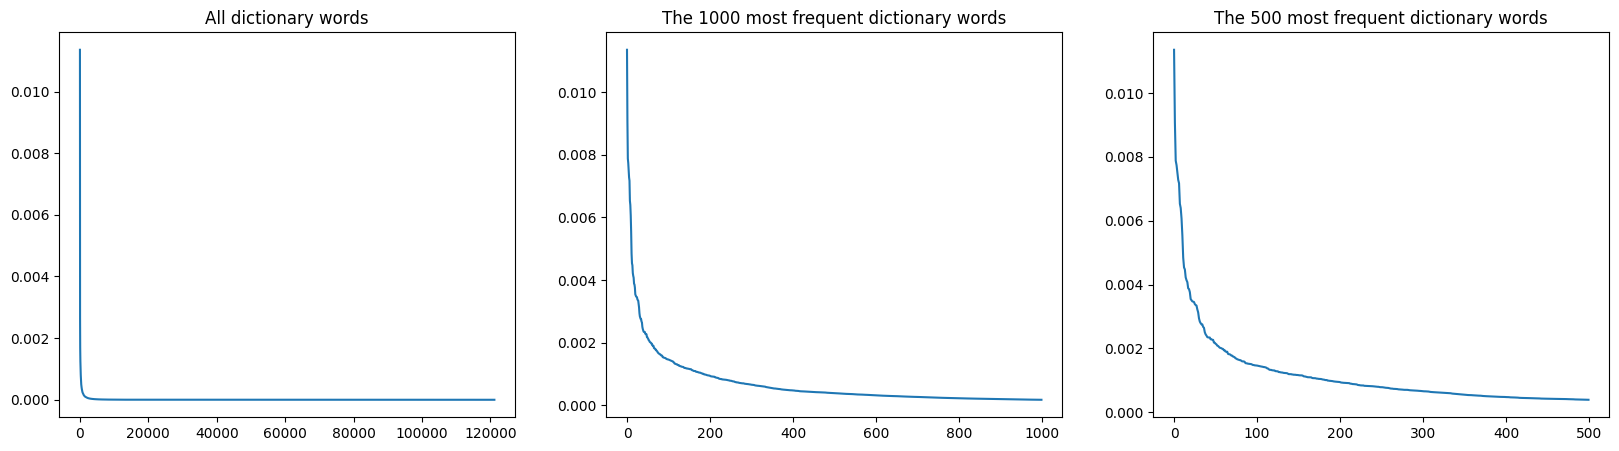

In [429]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (20, 5))
ax1.plot(np.transpose(-np.sort(-np.sum(bow_model,axis=0))/np.sum(bow_model)))
ax2.plot(np.transpose(-np.sort(-np.sum(bow_model,axis=0))/np.sum(bow_model))[0:1000])
ax3.plot(np.transpose(-np.sort(-np.sum(bow_model,axis=0))/np.sum(bow_model))[0:500])

ax1.set_title('All dictionary words')
ax2.set_title('The 1000 most frequent dictionary words')
ax3.set_title('The 500 most frequent dictionary words')

### Generating BoW model 
Generate BoW model for the four preprocessed datasets.

In [431]:
max_featuers=500

# Base
# Create a CountVectorizer object
bow = CountVectorizer(max_features=max_featuers)
# Fit and transform the training data
bow_model = bow.fit_transform(preprocessed_reviews)

# Base + Stemming
# Create a CountVectorizer object
bow_stem = CountVectorizer(max_features=max_featuers)
# Fit and transform the training data
bow_model_stem = bow_stem.fit_transform(preprocessed_reviews_stemmed)

# Base + Tagging
# Create a CountVectorizer object
bow_tag = CountVectorizer(max_features=max_featuers)
# Fit and transform the training data
bow_model_tag = bow_tag.fit_transform(preprocessed_reviews_tag)

# Base + Tagging + Stemming
# Create a CountVectorizer object
bow_tag_stem = CountVectorizer(max_features=max_featuers)
# Fit and transform the training data
bow_model_tag_stem = bow_tag_stem.fit_transform(preprocessed_reviews_tag_stemmed)

### Used word count for the BoW models
Plotting the total number of words in the BoW model shows that stemming increases the number of words in the corpus assigned to a dictionary word. This suggests that there are multiple variants of words, some of which are frequent enough to be included, while others are ignored due to low frequency. Stemming aligns these variants so that they can be assigned to the dictionary and considered for vectorization.
Furthermore, selecting only ADJ, ADV, VERB and NOUN reduces the number of considered words as expected. However, applying stemming afterwards increases the number of words even more than the basic preprocessing. This indicates that stemming is effective for these four word types.

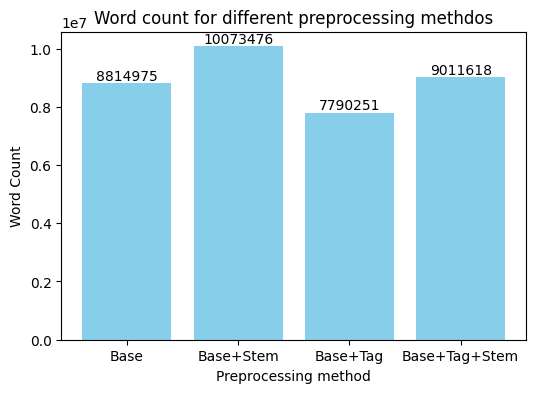

In [446]:
cons_words = np.array([bow_model.sum(),bow_model_stem.sum(),bow_model_tag.sum(),bow_model_tag_stem.sum()])

# Plotting with adjustments
plt.figure(figsize=(6, 4)) 
plt.bar(['Base','Base+Stem','Base+Tag','Base+Tag+Stem'],cons_words, color='skyblue')
plt.xlabel('Preprocessing method')
plt.ylabel('Word Count')
plt.title('Word count for different preprocessing methdos')
plt.text(0.5, max(cons_words) + 5, '', horizontalalignment='center', verticalalignment='bottom', fontsize=10)
for i, count in enumerate(cons_words):
    plt.text(i, count + 2, str(count), horizontalalignment='center', verticalalignment='bottom', fontsize=10)

plt.show()

### Dictionary Word Frequencies
These plots show the frequencies of dictionary words after different preprocessing methods. The words in each dictionary are sorted by frequency, so the IDs on the x-axis do not correspond to the same word in all datasets. Stemming, applied after basic preprocessing and tag selection, results in higher word frequencies across several ranges. This suggests that the use of stemming can enhance the information of the corpus by minimizing word variation.

In [465]:
# Sort dictionaries based on word frequency
sort_args = np.transpose(np.argsort(-np.sum(bow_model,axis=0)))
sort_args_stem = np.transpose(np.argsort(-np.sum(bow_model_stem,axis=0)))
sort_args_tag = np.transpose(np.argsort(-np.sum(bow_model_tag,axis=0)))
sort_args_tag_stem = np.transpose(np.argsort(-np.sum(bow_model_tag_stem,axis=0)))

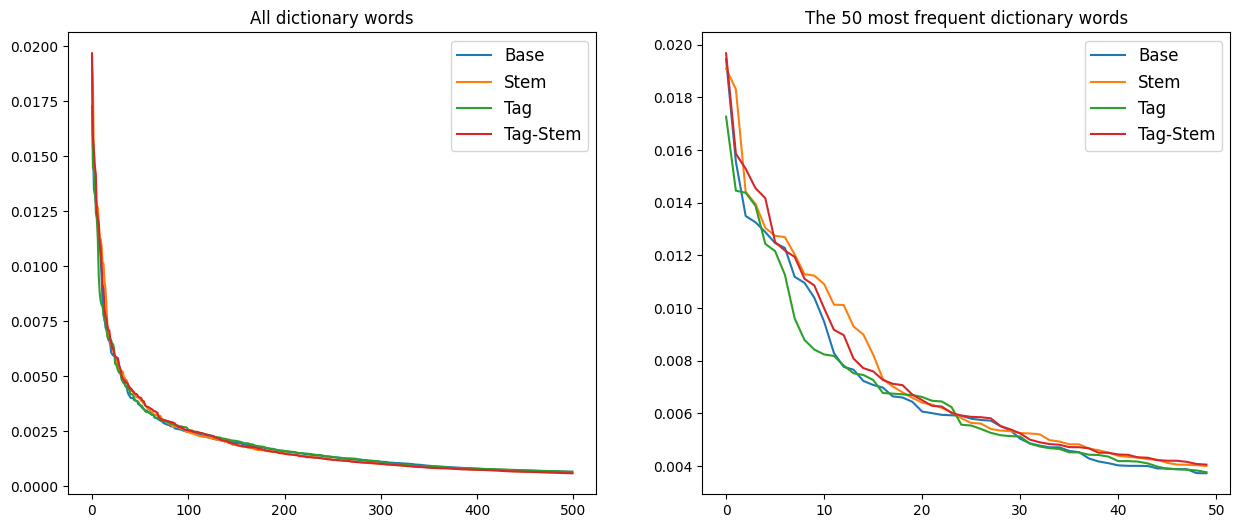

In [548]:
norm_wcount = np.transpose(np.sum(bow_model,axis=0)/bow_model.sum())
norm_wcount_stem = np.transpose(np.sum(bow_model_stem,axis=0)/bow_model_stem.sum())
norm_wcount_tag = np.transpose(np.sum(bow_model_tag,axis=0)/bow_model_tag.sum())
norm_wcount_tag_stem = np.transpose(np.sum(bow_model_tag_stem,axis=0)/bow_model_tag_stem.sum())



fig, [ax1,ax2] = plt.subplots(1,2, figsize = (15, 6))

ax1.plot(np.transpose(np.squeeze(norm_wcount[sort_args])))
ax1.plot(np.transpose(np.squeeze(norm_wcount_stem[sort_args_stem])))
ax1.plot(np.transpose(np.squeeze(norm_wcount_tag[sort_args_tag])))
ax1.plot(np.transpose(np.squeeze(norm_wcount_tag_stem[sort_args_tag_stem])))


ax2.plot(np.transpose(np.squeeze(norm_wcount[sort_args]))[0:50])
ax2.plot(np.transpose(np.squeeze(norm_wcount_stem[sort_args_stem]))[0:50])
ax2.plot(np.transpose(np.squeeze(norm_wcount_tag[sort_args_tag]))[0:50])
ax2.plot(np.transpose(np.squeeze(norm_wcount_tag_stem[sort_args_tag_stem]))[0:50])


ax1.set_title('All dictionary words')
ax1.legend(['Base','Stem', 'Tag','Tag-Stem'], prop={'size': 11})

ax2.set_title('The 50 most frequent dictionary words')
ax2.legend(['Base','Stem', 'Tag','Tag-Stem'], prop={'size': 11})


### Prominent Dictionary Words

Creating a word cloud using dictionary frequency data illustrates the shifts in prominent words with different preprocessing methods. Including ADJ, ADV, VERB, and NOUN along with stemming results in words that are more appropriate to the tone of the text. Notably, words such as "would" and "one" are absent from the most prominent set, reflecting the impact of the chosen preprocessing techniques.

Text(0.5, 1.0, 'Base preprocessing + Tag + Stemming')

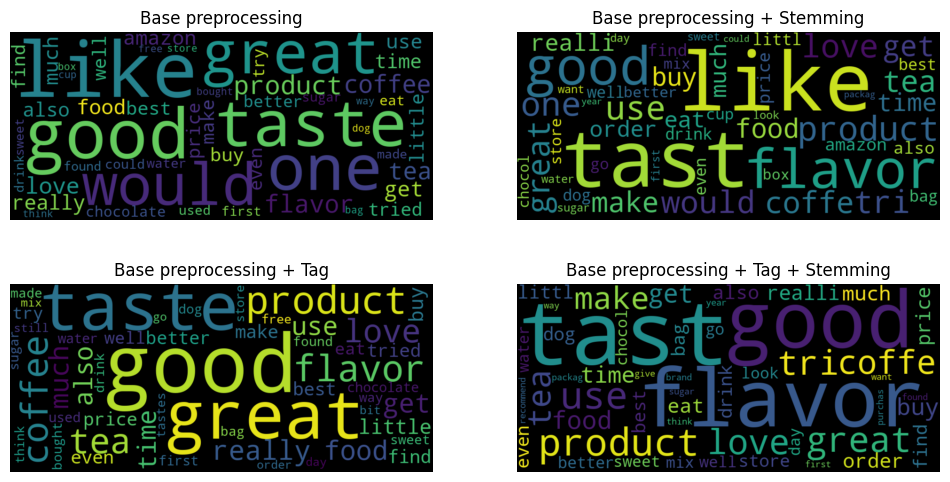

In [547]:

fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize = (12, 6))

data_wc = dict(zip(bow.get_feature_names_out(bow_model).tolist(), np.sum(bow_model,axis=0).tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax1.imshow(wc, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Base preprocessing')

data_wc = dict(zip(bow_stem.get_feature_names_out(bow_model_stem).tolist(), np.sum(bow_model_stem,axis=0).tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax2.imshow(wc, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Base preprocessing + Stemming')

data_wc = dict(zip(bow_tag.get_feature_names_out(bow_model_tag).tolist(), np.sum(bow_model_tag,axis=0).tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax3.imshow(wc, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Base preprocessing + Tag')


data_wc = dict(zip(bow_tag_stem.get_feature_names_out(bow_model_tag_stem).tolist(), np.sum(bow_model_tag_stem,axis=0).tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax4.imshow(wc, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('Base preprocessing + Tag + Stemming')


### Positive vs. Negative Comments

The generated dictionaries for the positive and negative comments are explored.

#### Dictionary Word Frequency

The frequencies of words in different dictionaries across positive and negative samples are calculated and graphed. To facilitate comparison, words in each dictionary are sorted by their frequency in positive comments. While the frequencies in negative comments don't exactly match those in positive comments, the overall patterns are close. This suggests a high similarity in word frequencies with some variation. Calculating the relative entropy between the positive and negative distributions using the Kulback-Liebler divergence algorithm reveals larger differences when tag selection is applied (using ADJ, ADV, NOUN, and VERB). The larger difference between the word distributions may indicate the greater discriminability of the two sets using the dictionary.


In [557]:
# Sort dictionaries based on word frequency for positive comments
sort_args_pos = np.transpose(np.argsort(-np.sum(bow_model[df['sentiment']=='positive'],axis=0)))
sort_args_stem_pos = np.transpose(np.argsort(-np.sum(bow_model_stem[df['sentiment']=='positive'],axis=0)))
sort_args_tag_pos = np.transpose(np.argsort(-np.sum(bow_model_tag[df['sentiment']=='positive'],axis=0)))
sort_args_tag_stem_pos = np.transpose(np.argsort(-np.sum(bow_model_tag_stem[df['sentiment']=='positive'],axis=0)))

KL Divergence as difference between vocabulary word distributions for Positive and Negative comments:
Base preprocessing: 0.1057
Base preprocessing + Stemming: 0.1027
Base preprocessing + Tag: 0.1113
Base preprocessing + Tag + Stemming: 0.1105


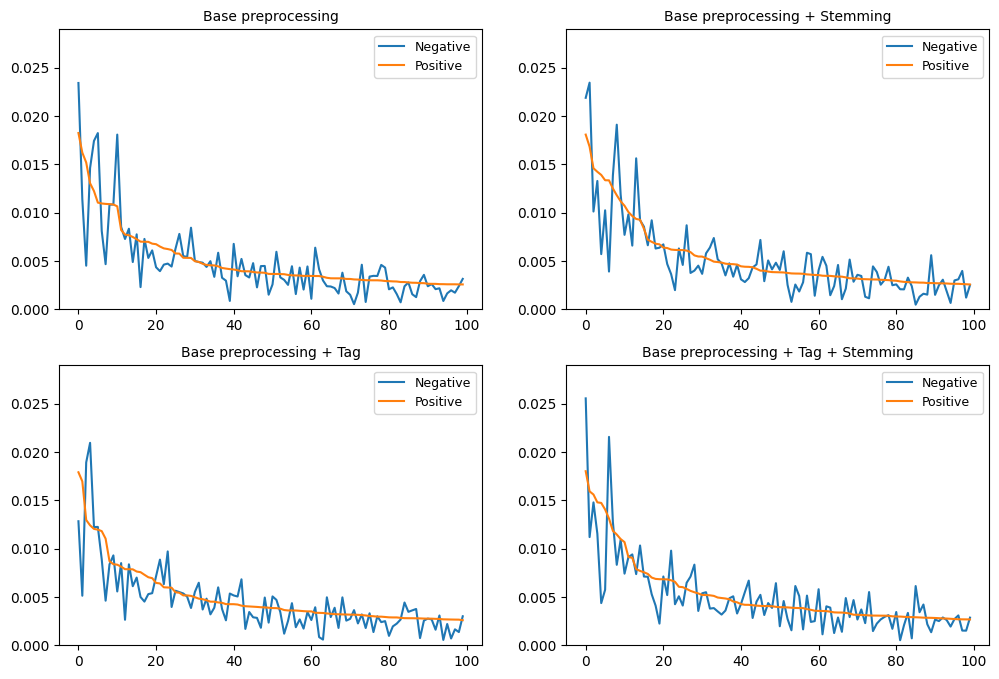

In [588]:
norm_wcount_pos = np.transpose(np.sum(bow_model[df['sentiment']=='positive'],axis=0)/bow_model[df['sentiment']=='positive'].sum())
norm_wcount_neg = np.transpose(np.sum(bow_model[df['sentiment']=='negative'],axis=0)/bow_model[df['sentiment']=='negative'].sum())
#
norm_wcount_stem_pos = np.transpose(np.sum(bow_model_stem[df['sentiment']=='positive'],axis=0)/bow_model_stem[df['sentiment']=='positive'].sum())
norm_wcount_stem_neg = np.transpose(np.sum(bow_model_stem[df['sentiment']=='negative'],axis=0)/bow_model_stem[df['sentiment']=='negative'].sum())
#
norm_wcount_tag_pos = np.transpose(np.sum(bow_model_tag[df['sentiment']=='positive'],axis=0)/bow_model_tag[df['sentiment']=='positive'].sum())
norm_wcount_tag_neg = np.transpose(np.sum(bow_model_tag[df['sentiment']=='negative'],axis=0)/bow_model_tag[df['sentiment']=='negative'].sum())
#
norm_wcount_tag_stem_pos = np.transpose(np.sum(bow_model_tag_stem[df['sentiment']=='positive'],axis=0)/bow_model_tag_stem[df['sentiment']=='positive'].sum())
norm_wcount_tag_stem_neg = np.transpose(np.sum(bow_model_tag_stem[df['sentiment']=='negative'],axis=0)/bow_model_tag_stem[df['sentiment']=='negative'].sum())


fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize = (12, 8))

ax1.plot(norm_wcount_neg[sort_args_pos].squeeze().transpose()[0:100])
ax1.plot(norm_wcount_pos[sort_args_pos].squeeze().transpose()[0:100])

ax2.plot(norm_wcount_stem_neg[sort_args_stem_pos].squeeze().transpose()[0:100])
ax2.plot(norm_wcount_stem_pos[sort_args_stem_pos].squeeze().transpose()[0:100])

ax3.plot(norm_wcount_tag_neg[sort_args_tag_pos].squeeze().transpose()[0:100])
ax3.plot(norm_wcount_tag_pos[sort_args_tag_pos].squeeze().transpose()[0:100])

ax4.plot(norm_wcount_tag_stem_neg[sort_args_tag_stem_pos].squeeze().transpose()[0:100])
ax4.plot(norm_wcount_tag_stem_pos[sort_args_tag_stem_pos].squeeze().transpose()[0:100])


ax1.set_title('Base preprocessing', fontsize=10)
ax2.set_title('Base preprocessing + Stemming', fontsize=10)
ax3.set_title('Base preprocessing + Tag', fontsize=10)
ax4.set_title('Base preprocessing + Tag + Stemming', fontsize=10)

ax1.legend(['Negative','Positive'], prop={'size': 9})
ax2.legend(['Negative','Positive'], prop={'size': 9})
ax3.legend(['Negative','Positive'], prop={'size': 9})
ax4.legend(['Negative','Positive'], prop={'size': 9})




ax1.set_ylim([0, 0.029])
ax2.set_ylim([0, 0.029])
ax3.set_ylim([0, 0.029])
ax4.set_ylim([0, 0.029])

print('KL Divergence as difference between vocabulary word distributions for Positive and Negative comments:')
print('Base preprocessing: %.4f' % ((rel_entr(norm_wcount_pos,norm_wcount_neg).sum() + rel_entr(norm_wcount_neg,norm_wcount_pos).sum())/2))
print('Base preprocessing + Stemming: %.4f' % ((rel_entr(norm_wcount_stem_pos,norm_wcount_stem_neg).sum() + rel_entr(norm_wcount_stem_neg,norm_wcount_stem_pos).sum())/2))
print('Base preprocessing + Tag: %.4f' % ((rel_entr(norm_wcount_tag_pos,norm_wcount_tag_neg).sum() + rel_entr(norm_wcount_tag_neg,norm_wcount_tag_pos).sum())/2))
print('Base preprocessing + Tag + Stemming: %.4f' % ((rel_entr(norm_wcount_tag_stem_pos,norm_wcount_tag_stem_neg).sum() + rel_entr(norm_wcount_tag_stem_neg,norm_wcount_tag_stem_pos).sum())/2))


#### Dictionary Word Entropy

To evaluate the distribution of each word in the corpus, the occurrences of the word in the samples are counted and a probability distribution is derived. The entropy of this distribution is then calculated, assuming that words with more meaningful occurrences will have larger entropies. The entropies for positive and negative samples are calculated and plotted. For better understanding and comparability with frequency plots, words are sorted according to their frequency in positive samples, similar to the previous plots.

As can be seen, entropies often deviate from word frequencies, indicating that higher frequencies do not necessarily lead to higher entropies. Another observation is that entropies for positive samples tend to be larger than those for negative samples. This suggests that discriminative words may be more biased toward positive samples and may not adequately represent negative samples. The significant imbalance between the number of positive and negative samples may contribute to this discrepancy.


In [590]:
dense_x_train = bow_model.todense()
word_entropy_pos = np.zeros((bow_model_tag_stem.shape[1],1))
word_entropy_neg = np.zeros((bow_model_tag_stem.shape[1],1))

for i in range(bow_model_tag_stem.shape[1]):
    word_entropy_pos[i] = entropy(dense_x_train[df['sentiment']=='positive',i]/np.sum(dense_x_train[df['sentiment']=='positive',i]))
    word_entropy_neg[i] = entropy(dense_x_train[df['sentiment']=='negative',i]/np.sum(dense_x_train[df['sentiment']=='negative',i]))
    

dense_x_train = bow_model_stem.todense()
word_entropy_stem_pos = np.zeros((bow_model_stem.shape[1],1))
word_entropy_stem_neg = np.zeros((bow_model_stem.shape[1],1))

for i in range(bow_model_tag_stem.shape[1]):
    word_entropy_stem_pos[i] = entropy(dense_x_train[df['sentiment']=='positive',i]/np.sum(dense_x_train[df['sentiment']=='positive',i]))
    word_entropy_stem_neg[i] = entropy(dense_x_train[df['sentiment']=='negative',i]/np.sum(dense_x_train[df['sentiment']=='negative',i]))
    

dense_x_train = bow_model_tag.todense()
word_entropy_tag_pos = np.zeros((bow_model_tag.shape[1],1))
word_entropy_tag_neg = np.zeros((bow_model_tag.shape[1],1))

for i in range(bow_model_tag_stem.shape[1]):
    word_entropy_tag_pos[i] = entropy(dense_x_train[df['sentiment']=='positive',i]/np.sum(dense_x_train[df['sentiment']=='positive',i]))
    word_entropy_tag_neg[i] = entropy(dense_x_train[df['sentiment']=='negative',i]/np.sum(dense_x_train[df['sentiment']=='negative',i]))
    
    

dense_x_train = bow_model_tag_stem.todense()
word_entropy_tag_stem_pos = np.zeros((bow_model_tag_stem.shape[1],1))
word_entropy_tag_stem_neg = np.zeros((bow_model_tag_stem.shape[1],1))

for i in range(bow_model_tag_stem.shape[1]):
    word_entropy_tag_stem_pos[i] = entropy(dense_x_train[df['sentiment']=='positive',i]/np.sum(dense_x_train[df['sentiment']=='positive',i]))
    word_entropy_tag_stem_neg[i] = entropy(dense_x_train[df['sentiment']=='negative',i]/np.sum(dense_x_train[df['sentiment']=='negative',i])) 


(6.1, 11.9)

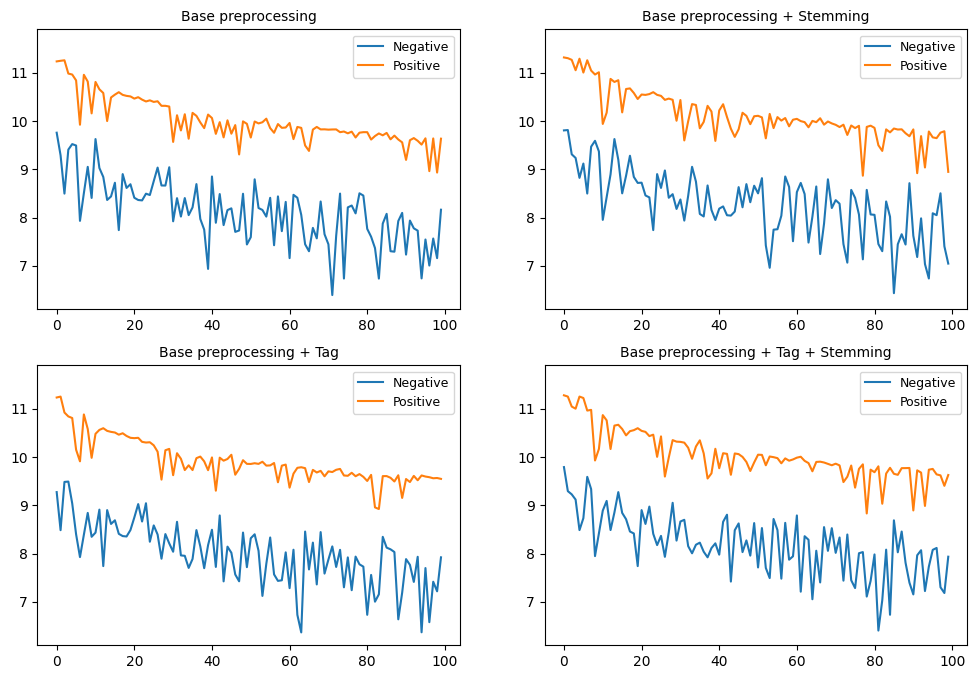

In [601]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize = (12, 8))

ax1.plot(word_entropy_neg[sort_args_pos].squeeze().transpose()[0:100])
ax1.plot(word_entropy_pos[sort_args_pos].squeeze().transpose()[0:100])

ax2.plot(word_entropy_stem_neg[sort_args_stem_pos].squeeze().transpose()[0:100])
ax2.plot(word_entropy_stem_pos[sort_args_stem_pos].squeeze().transpose()[0:100])

ax3.plot(word_entropy_tag_neg[sort_args_tag_pos].squeeze().transpose()[0:100])
ax3.plot(word_entropy_tag_pos[sort_args_tag_pos].squeeze().transpose()[0:100])

ax4.plot(word_entropy_tag_stem_neg[sort_args_tag_stem_pos].squeeze().transpose()[0:100])
ax4.plot(word_entropy_tag_stem_pos[sort_args_tag_stem_pos].squeeze().transpose()[0:100])


ax1.set_title('Base preprocessing', fontsize=10)
ax2.set_title('Base preprocessing + Stemming', fontsize=10)
ax3.set_title('Base preprocessing + Tag', fontsize=10)
ax4.set_title('Base preprocessing + Tag + Stemming', fontsize=10)

ax1.legend(['Negative','Positive'], prop={'size': 9})
ax2.legend(['Negative','Positive'], prop={'size': 9})
ax3.legend(['Negative','Positive'], prop={'size': 9})
ax4.legend(['Negative','Positive'], prop={'size': 9})



ax1.set_ylim([6.1, 11.9])
ax2.set_ylim([6.1, 11.9])
ax3.set_ylim([6.1, 11.9])
ax4.set_ylim([6.1, 11.9])


Text(0.5, 1.0, 'Base preprocessing + Tag + Stem (Negative)')

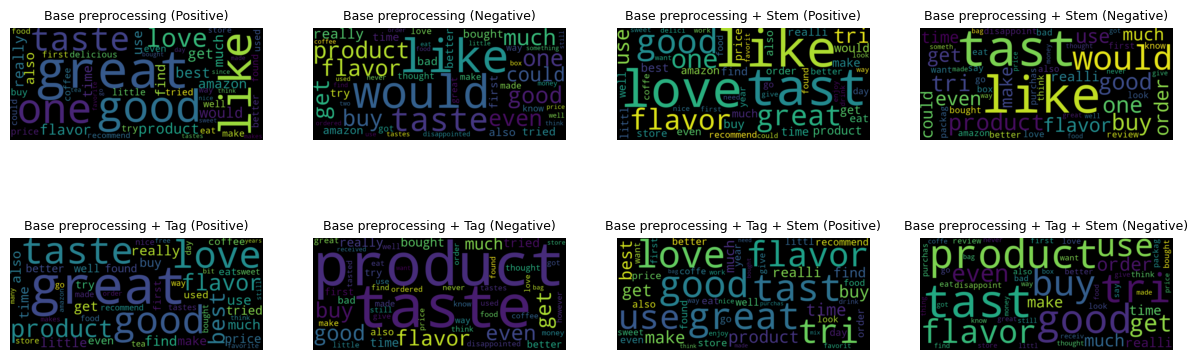

In [626]:
fSize = 9

fig, [[ax1,ax2,ax3,ax4], [ax5,ax6,ax7,ax8]] = plt.subplots(2,4, figsize = (15, 5))

data_wc = dict(zip(bow.get_feature_names_out(bow_model).tolist(), word_entropy_pos.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax1.imshow(wc, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Base preprocessing (Positive)', fontsize=fSize)

data_wc = dict(zip(bow.get_feature_names_out(bow_model).tolist(), word_entropy_neg.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax2.imshow(wc, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Base preprocessing (Negative)', fontsize=fSize)

data_wc = dict(zip(bow_stem.get_feature_names_out(bow_model_stem).tolist(), word_entropy_stem_pos.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax3.imshow(wc, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Base preprocessing + Stem (Positive)', fontsize=fSize)

data_wc = dict(zip(bow_stem.get_feature_names_out(bow_model_stem).tolist(), word_entropy_stem_neg.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax4.imshow(wc, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('Base preprocessing + Stem (Negative)', fontsize=fSize)


data_wc = dict(zip(bow_tag.get_feature_names_out(bow_model_tag).tolist(), word_entropy_tag_pos.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax5.imshow(wc, interpolation='bilinear')
ax5.axis('off')
ax5.set_title('Base preprocessing + Tag (Positive)', fontsize=fSize)

data_wc = dict(zip(bow_tag.get_feature_names_out(bow_model_tag).tolist(), word_entropy_tag_neg.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax6.imshow(wc, interpolation='bilinear')
ax6.axis('off')
ax6.set_title('Base preprocessing + Tag (Negative)', fontsize=fSize)

data_wc = dict(zip(bow_tag_stem.get_feature_names_out(bow_model_tag_stem).tolist(), word_entropy_tag_stem_pos.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax7.imshow(wc, interpolation='bilinear')
ax7.axis('off')
ax7.set_title('Base preprocessing + Tag + Stem (Positive)', fontsize=fSize)

data_wc = dict(zip(bow_tag_stem.get_feature_names_out(bow_model_tag_stem).tolist(), word_entropy_tag_stem_neg.transpose().tolist()[0]))
wc = WordCloud(width=900, height=400, max_words=50).generate_from_frequencies(data_wc)
ax8.imshow(wc, interpolation='bilinear')
ax8.axis('off')
ax8.set_title('Base preprocessing + Tag + Stem (Negative)', fontsize=fSize)


## 5. Clean Text

- Now creates a new column named 'clean_text' in the DataFrame df and assigns the values from the preprocessed_reviews list to this column. The preprocessed_reviews list seems to contain preprocessed text data, possibly cleaned and tokenized.


- then reorders the columns in the DataFrame, selecting only the 'Time', 'clean_text', and 'Score' columns and updating the DataFrame with this new selection.

In [668]:
def null_remove(df):
    null_index = []
    for i,ele in enumerate(df['clean_text']):
        if len(ele) == 0:
            null_index.append(i)
    return df.drop(null_index)

In [669]:
#combining required columns
df_out = df
df_out['clean_text'] = preprocessed_reviews
df_out = df_out[['Time','clean_text','Score']]
#reseting index
df_out = df_out.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
df_out = null_remove(df_out)
#saving processed file
df_out.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df_base.csv',index=False)

df_out = df
df_out['clean_text'] = preprocessed_reviews_stemmed
df_out = df_out[['Time','clean_text','Score']]
#reseting index
df_out = df_out.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
df_out = null_remove(df_out)
#saving processed file
df_out.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df_stem.csv',index=False)

df_out = df
df_out['clean_text'] = preprocessed_reviews_tag
df_out = df_out[['Time','clean_text','Score']]
#reseting index
df_out = df_out.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
df_out = null_remove(df_out)
#saving processed file
df_out.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df_tag.csv',index=False)

df_out = df
df_out['clean_text'] = preprocessed_reviews_tag_stemmed
df_out = df_out[['Time','clean_text','Score']]
#reseting index
df_out = df_out.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
df_out = null_remove(df_out)
#saving processed file
df_out.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df_tag_stem.csv',index=False)

In [707]:
# Reading the preprocessed file
df_in = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df_base.csv')
df_in.head()

,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,5
1,1346976000,product arrived labeled jumbo salted peanuts p...,1
2,1219017600,confection around centuries light pillowy citr...,4
3,1307923200,looking secret ingredient robitussin believe f...,2
4,1350777600,great taffy great price wide assortment yummy ...,5


In [708]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392917 entries, 0 to 392916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        392917 non-null  int64 
 1   clean_text  392917 non-null  object
 2   Score       392917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.0+ MB


In [709]:
df_in.clean_text.isnull().any()

False

Analyzing text data over time is crucial for gaining insights into evolving patterns, sentiments, and user behaviors. Time provides context for understanding temporal trends, seasonal variations, and the impact of events on language. It also allows for the detection of linguistic shifts, user sentiment changes, and the dynamic evolution of terms. Incorporating a temporal perspective in text analysis enables more accurate predictions, cohort analysis, and a nuanced understanding of how language and sentiments adapt to changing circumstances.

- We are considering **time** beacuse our reviews are developed over time, so splitting based on that makes more sense

In [710]:
 df_in = df_in.sample(100000,random_state=42)

In [711]:
df_in.shape

(100000, 3)

In [712]:
#sortimg based on time
df_in['Time'] = pd.to_datetime(df_in['Time'],unit='s')
df_in = df_in.sort_values('Time')
df_in = df_in.reset_index(drop=True)

## 6. Splitting data

- Train test split
Once we are done with preprocessing, we will split our data into train and test. We will do splitting after sorting the data based on time as a change in time can influence the reviews.

In [713]:
X = df_in['clean_text']
y = df_in['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=42)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (70000,)
shape of X_test is (30000,)
shape of y_train is (70000,)
shape of y_test is (30000,)


It's common to experiment with multiple methods to find the one that works best for the  sentiment analysis problem.

but we can start with simplicity: Begin with Bag-of-Words or TF-IDF, especially if our dataset is not extremely large. These methods are simple and can provide good results for sentiment analysis tasks.

# Bag of Words (bow)

In [714]:
bow_ev = CountVectorizer(max_features=500) # entire vocabulary
bow_ev.fit(X_train) 
X_train_bow = bow_ev.transform(X_train)
X_test_bow = bow_ev.transform(X_test)
bow_features = bow_ev.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (70000, 500)
shape of X_test_bow is (30000, 500)


In [681]:
#saving bow vectors
#import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

## Loading saved vectors

In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


In [715]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Naive Bayes
param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 1],
    #'fit_prior': [True, False],  # Whether to learn class prior probabilities or not
    #'class_prior': [None, [0.2, 0.3, 0.1, 0.2, 0.2]]  # Prior probabilities of the classes
}

# Create Naive Bayes model
nb_model = MultinomialNB()

# Create GridSearchCV object
model_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, return_train_score=True, scoring='f1_macro')
model_nb.fit(X_train_bow, y_train)

# Print the best parameters
print("Model with best parameters:\n", model_nb.best_params_)

Model with best parameters:
 {'alpha': 0.001}
CPU times: total: 1.22 s
Wall time: 1.32 s


In [716]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the best model to make predictions on the test set
y_pred = model_nb.predict(X_test_bow)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.43      0.50      0.46      2765
           2       0.23      0.09      0.13      1586
           3       0.29      0.20      0.24      2241
           4       0.35      0.25      0.29      4297
           5       0.77      0.87      0.82     19111

    accuracy                           0.66     30000
   macro avg       0.41      0.38      0.39     30000
weighted avg       0.61      0.66      0.63     30000



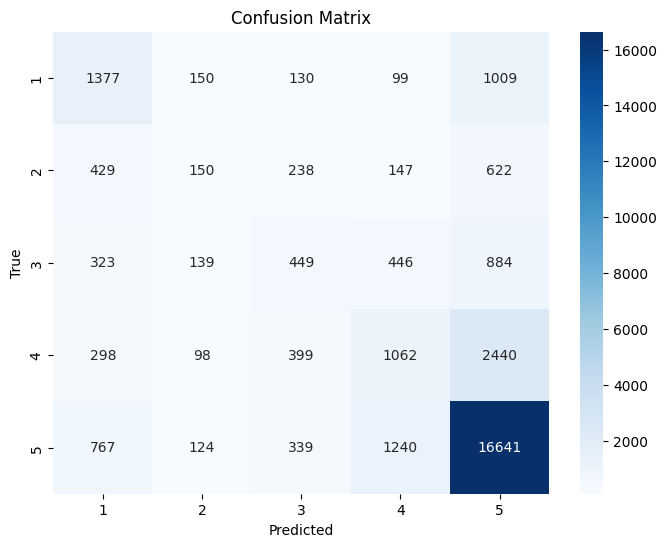

In [717]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [719]:
from sklearn.linear_model import LogisticRegression

In [720]:
%%time
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [ 0.001, 0.01, 0.1, 1]}

# Create Logistic Regression model
logreg = LogisticRegression(solver='liblinear',max_iter=1000)

# Create GridSearchCV object
model_logreg = GridSearchCV(logreg, param_grid, cv=5, return_train_score=True, scoring='f1_macro')
model_logreg.fit(X_train_bow, y_train)

# Print the best parameters
print("Model with best parameters:\n", model_logreg.best_params_)

Model with best parameters:
 {'C': 1, 'penalty': 'l2'}
CPU times: total: 1min 14s
Wall time: 1min 16s


In [721]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the best model to make predictions on the test set
y_pred = model_logreg.predict(X_test_bow)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.40      0.46      2765
           2       0.26      0.04      0.07      1586
           3       0.37      0.11      0.17      2241
           4       0.44      0.15      0.22      4297
           5       0.72      0.96      0.82     19111

    accuracy                           0.68     30000
   macro avg       0.46      0.33      0.35     30000
weighted avg       0.61      0.68      0.62     30000



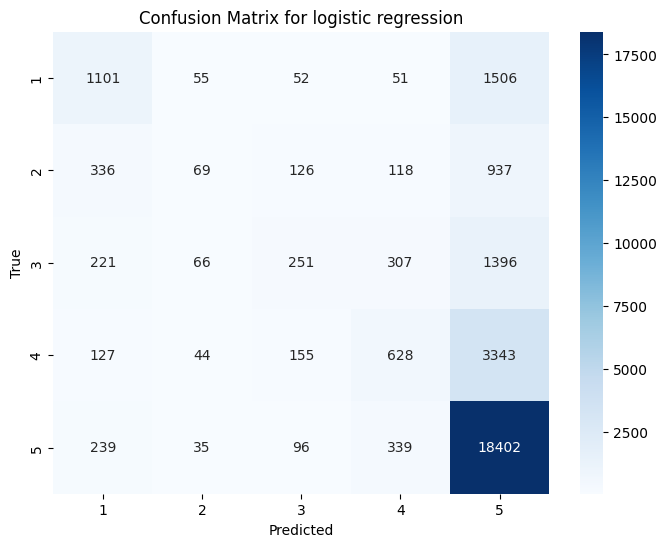

In [722]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix for logistic regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()